In [1]:
"""!pip install jupyter-tabnine
!jupyter nbextension install --py jupyter_tabnine
!jupyter nbextension enable --py jupyter_tabnine
!jupyter serverextension enable --py jupyter_tabnine"""

'!pip install jupyter-tabnine\n!jupyter nbextension install --py jupyter_tabnine\n!jupyter nbextension enable --py jupyter_tabnine\n!jupyter serverextension enable --py jupyter_tabnine'

# Prepre the data and tools

 imports

In [2]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")


Load the data

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
ss = pd.read_csv('data/sample_submission.csv')

train.shape, test.shape

((27481, 4), (3534, 3))

In [4]:
 train.sample(5)

,textID,text,selected_text,sentiment
21184,4ff027de24,"Walking the puppies downtown. Also, mystery of...",missing,negative
1916,9f99fb6260,I`m so down again. I wish I could share my pr...,I`m so down again.,negative
23196,d6f0e4ac5e,just bought a good chocolate and a magazine......,good,positive
26963,f83603a1f2,I`m watching it at the moment -sighs- and st...,h takes hours,negative
6518,777e9e8289,says I LOVE YOU MOM http://plurk.com/p/svm0w,LOVE,positive


In [5]:
target = 'sentiment'

# Exploratory Data Analysis

In [6]:
train.describe(exclude='number')

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,61180babcd,Another day and I couldn`t find you. I end...,good,neutral
freq,1,1,199,11118


In [7]:
def check_missing_data(df):
    """ 
    params: dataframe
    return: data of missing values, if have some.
    """
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(output[output['Percent'] > 0].sort_values(by='Percent', ascending=False))
    else:
        return(False)

In [8]:
missing_df = check_missing_data(train)
missing_df

,Total,Percent,Types
text,1,3.638878e-07,object
selected_text,1,3.638878e-07,object


missing values on train

In [9]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


NameError: name 'ax' is not defined

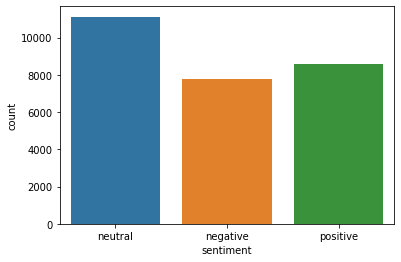

In [10]:
sns.countplot(target,data=train)
ax[1].set_title(target)
plt.show()

delete row if miss variable

In [ ]:
train = train.dropna()

clean text

In [ ]:
# def clean_text(text):
#     text = str(text).lower()
#     return text

In [ ]:
# train['text'] = train['text'].apply(clean_text)

In [ ]:
train.head()

# Feature Engeniring

 jaccard similarity 

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
train['jaccard'] = [jaccard(a, b) for a, b in zip(train['text'], train['selected_text'])]


In [ ]:
train.groupby('sentiment').mean()['jaccard']

In [ ]:
train.groupby('sentiment').mean()['jaccard'].plot.bar();

len feature and word count

In [11]:
train['text_len'] = train['text'].astype(str).apply(len)
train['text_word_count'] = train['text'].apply(lambda x: len(str(x).split()))

In [12]:
# sns.kdeplot(train, x="text_word_count",hue="sentiment", multiple="stack")

# Modeling

## Bert

In [13]:
!pip install -q tensorflow-text

ERROR: astroid 2.3.1 requires typed-ast<1.5,>=1.4.0; implementation_name == "cpython" and python_version < "3.8", which is not installed.
ERROR: pandas 0.25.1 has requirement python-dateutil>=2.6.1, but you'll have python-dateutil 2.2 which is incompatible.
ERROR: astroid 2.3.1 has requirement six==1.12, but you'll have six 1.15.0 which is incompatible.
ERROR: astroid 2.3.1 has requirement wrapt==1.11.*, but you'll have wrapt 1.12.1 which is incompatible.
ERROR: anaconda-client 1.7.2 has requirement python-dateutil>=2.6.1, but you'll have python-dateutil 2.2 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\avi\\anaconda3\\lib\\site-packages\\~-mpy\\.libs\\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [14]:
!pip install -q tf-models-official

ERROR: petrarch2 1.0.0 has requirement python-dateutil==2.2, but you'll have python-dateutil 2.8.1 which is incompatible.
ERROR: tensorflow-metadata 0.25.0 has requirement absl-py<0.11,>=0.9, but you'll have absl-py 0.11.0 which is incompatible.
ERROR: tensorflow 2.3.1 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: google-api-core 1.23.0 has requirement google-auth<2.0dev,>=1.21.1, but you'll have google-auth 1.17.2 which is incompatible.


In [15]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

ContextualVersionConflict: (six 1.12.0 (c:\users\avi\anaconda3\lib\site-packages), Requirement.parse('six<2dev,>=1.13.0'), {'google-api-python-client'})